# Before you start

💡 **You should be able to run this notebook on the free-tier runtime in Google Colab.**

Import the following modules into the runtime. Feel free to install and use other packages – however we will need these at a minimum:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

# Overview

The notebook is split into three sections.

The first two sections are on **data exploration and cleaning** in preparation for fine-tuning a large language model to act as an evaluator.

The final section is a more open-ended task on **critique analysis**. Here, we'll provide a set of raw results from an evaluator model; your job is to analyse these results – the critiques in particular – to try to improve the evaluator.

## 🚨 Expectations and Guidelines
**Implementation**: Fill in the sections marked `TODO`. Don't overoptimise on cleaning up the final notebook but rather show us the process of how you have built up your solution.

**Documentation**: Document your process, including thoughts on improvements, challenges, and resources used. You can directly document your thoughts in the notebook or as comments in the code where appropriate. Bullet points are sufficient.

**Resources**: You may use any public resource, including publications, online materials, or code snippets from repositories like GitHub. Please cite all sources used.

**Data Framework Flexibility**: Below, we assume that you will read the input data CSV file into a Pandas DataFrame.  However, if you prefer to work with Python dictionaries or any other framework, feel free to modify the code.

# Let's start

## Part 1A: Data Exploration
In this section, you will begin by exploring the dataset provided in the file `small_eval_dataset.csv`.

You can access the file through this Google Drive [link](https://drive.google.com/file/d/1d8gidGs_JEWnTjo5xFZoWOisWcuEKigb/view?usp=share_link).

Get the file and upload it to the temporary folder of this notebook to start with the exploration

In [2]:
# first, upload your file to Google Colab and load into a dataframe
df = pd.read_csv('./small_eval_dataset.csv').drop(columns="Unnamed: 0")
len(df)

10500

Below you will see the first 5 rows from this dataset.  Each row consists of a question/task and two responses generated by different language models, as well as a pair of evaluation scores assigned by GPT4 for the first and second responses respectively.  The modelling task will be to train GPT2 on single question + answer + score sequences.  At test time, the model would be presented with a question + response sequence and asked to predict the final score token.

Before we move onto data processing, let's do some exploratory data analysis.


In [3]:
# Set higher maximum column width in pandas so you can see full data points.
pd.set_option("max_colwidth", 400)
df.head(5)

,question_body,answer1_body,answer2_body,score
0,Generate a fun fact about the cuisines of Thailand.\n,"Thailand is known for its delicious street food, including pad Thai which is made from rice noodles, eggs, and coconut milk.","```\nThailand: The capital city of Thailand, known for its rich culture, delicious food, and breathtaking scenery. It is home to the famous Ao Bang Tower, offering stunning views of the city. With so many delicious food options, it is easy to explore and try new dishes without leaving your table.\n```\nThailand: The country's second-largest island after Indonesia, known for its pristine beache...","[6.0, 3.0]"
1,"\nWith regards to the philosophy of Stoicism, how do you define a good life?",a life lived well,"For me, a good life is one that is lived in accordance with virtue and reason. It is a life that is guided by the Stoic principles of self-control, wisdom, and justice. It is a life that is free from fear, anger, and other negative emotions, and is characterized by a sense of inner peace, tranquility, and contentment. A good life is one that is lived in harmony with oneself and with the world ...","[2.0, 9.0]"
2,\nWhere can I find affordable flight tickets?,"There are several ways to find affordable flight tickets. You can use flight aggregator websites such as Kayak, Expedia, or Skyscanner to compare prices across multiple airlines. You can also sign up for airline newsletters to receive deals and promotions. It's also a good idea to be flexible with your travel dates and book your ticket well in advance. Additionally, consider flying with budget...",flight.cheapfares.com\n\nI found these really cheap flight tickets from flight.cheapfares.com\n\n I found this really cheap flight ticket from flight.cheapfares.com\n\n - return flight from London to Pune for as low as $79\n\n - departs September 2020\n\n - only 2 days delay\n\n - roundtrip ticket\n\n - can be paid for in Indian rupees to save more\n\n - can be found using our website or simpl...,"[8.0, 6.0]"
3,"\nGenerate a brief description of a warm scene inside of a mansion with lamps, carpets, and a plush floor.","A mansion with plush carpets, lamps, and carpets that look like a rug, plush furniture, and a plush floor.","As you step into the grand foyer of the mansion, you're greeted by the warm glow of several lamps placed strategically throughout the room. The plush cream-colored carpet feels like a cloud beneath your feet as you walk further in. In the distance, you can see a cozy seating area with overstuffed armchairs, a roaring fireplace, and a soft blanket casually draped over the backrest. The ambiance...","[3.0, 9.0]"
4,\nWrite a character description for a fantasy rpg: Ginjiro is a Wood Elf male that lives in Gelbren.,"He has dark brown hair and dark brown eyes. He is slim and agile, and is very good at hiding and moving silently. He is wearing a dark green tunic, pants and boots. He carries a longbow, quiver of arrows and a short sword. He has a scar on his left cheek and a small tattoo of an owl on his neck. He is a skilled hunter and tracker, and is well known for his ability to sneak up on his prey undet...","He is 25 years old and works as a hunter. Ginjiro is a kind person, but he can be naive at times.\n rise/fall: Ginjirō is a 25 year old wood elf who works as a hunter. He is a kind person, but can be naive at times.\n\nWrite a character description for a fantasy rpg: Ginjiro is a 25 year old wood elf hunter who works as a kind person. Ginjirō is a naive person at times.\n\n: Ginjirō is a 25 ye...","[9.0, 2.0]"


In [4]:
# TODO: Exploratory Data Analysis.
# Things to consider:
#   - how suitable is this dataset for this task?
#   - how would you clean it up?
# Feel free to visualise any interesting distributional properties of the data.

## Part 1B: Data Cleaning and Preprocessing
Based on your data exploration in the previous section, you will now clean up the data and get it ready for the modelling task by extracting the two datapoints per row into a new preprocessed dataset.  You should also rescale the scores to integers in the range `[1, 5]` using the helper function below.  You may also want to insert special tokens to demarcate the three components.  

As an example, from the first row of the raw dataset you might extract the following two data points (we have truncated the second response for brevity):

>[QUESTION] Generate a fun fact about the cuisines of Thailand. [RESPONSE] Thailand is known for its delicious street food, including pad Thai which is made from rice noodles, eggs, and coconut milk. [SCORE] 3

>[QUESTION] Generate a fun fact about the cuisines of Thailand. [RESPONSE] ```
Thailand: The capital city of Thailand, known for its rich culture, delicious food, and breathtaking scenery. It is home to the famous Ao Bang Tower... [SCORE] 2

Store these strings in a column titled `input_text`.

### Exploring the types of data and number of NaN values in the df

In [5]:
for col in df.columns:
    print(f"Column: {col}")
    
    # Map each value to its type and count unique occurrences
    type_counts = df[col].apply(lambda x: type(x)).value_counts()
    print("Unique types:\n", type_counts)
    
    # Count NaN values
    nan_count = df[col].isna().sum()
    print(f"NaN count: {nan_count}")
    
    # Count empty strings (only applicable if the type is str)
    empty_count = df[col].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
    print(f"Empty string count: {empty_count}")
    
    print("-" * 40)


Column: question_body
Unique types:
 question_body
<class 'str'>    10500
Name: count, dtype: int64
NaN count: 0
Empty string count: 0
----------------------------------------
Column: answer1_body
Unique types:
 answer1_body
<class 'str'>      10491
<class 'float'>        9
Name: count, dtype: int64
NaN count: 9
Empty string count: 0
----------------------------------------
Column: answer2_body
Unique types:
 answer2_body
<class 'str'>      10494
<class 'float'>        6
Name: count, dtype: int64
NaN count: 6
Empty string count: 0
----------------------------------------
Column: score
Unique types:
 score
<class 'str'>      10462
<class 'float'>       38
Name: count, dtype: int64
NaN count: 38
Empty string count: 0
----------------------------------------


### Exploring the startswith and endswith of the answer bodies in the df

In [6]:
import pandas as pd

# Ensure missing values are replaced with empty strings
answer1 = df['answer1_body'].fillna('')
answer2 = df['answer2_body'].fillna('')
question = df['question_body'].fillna('')

# Create boolean masks for entries starting with a newline or a backtick
mask_newline = answer1.str.startswith("\\") | answer2.str.startswith("\n")
mask_backtick = answer1.str.startswith('`') | answer2.str.startswith('`')

question_newline = question.str.startswith("\n")
question_backtick = question.str.startswith("`")

# Extract rows where either answer starts with a newline
df_newline = df[mask_newline]

# Extract rows where either answer starts with a backtick
df_backtick = df[mask_backtick]

# Extract question newline
df_question_newline = df[question_newline]

# df_backtick.head()
df_question_newline.head(5)


,question_body,answer1_body,answer2_body,score
1,"\nWith regards to the philosophy of Stoicism, how do you define a good life?",a life lived well,"For me, a good life is one that is lived in accordance with virtue and reason. It is a life that is guided by the Stoic principles of self-control, wisdom, and justice. It is a life that is free from fear, anger, and other negative emotions, and is characterized by a sense of inner peace, tranquility, and contentment. A good life is one that is lived in harmony with oneself and with the world ...","[2.0, 9.0]"
2,\nWhere can I find affordable flight tickets?,"There are several ways to find affordable flight tickets. You can use flight aggregator websites such as Kayak, Expedia, or Skyscanner to compare prices across multiple airlines. You can also sign up for airline newsletters to receive deals and promotions. It's also a good idea to be flexible with your travel dates and book your ticket well in advance. Additionally, consider flying with budget...",flight.cheapfares.com\n\nI found these really cheap flight tickets from flight.cheapfares.com\n\n I found this really cheap flight ticket from flight.cheapfares.com\n\n - return flight from London to Pune for as low as $79\n\n - departs September 2020\n\n - only 2 days delay\n\n - roundtrip ticket\n\n - can be paid for in Indian rupees to save more\n\n - can be found using our website or simpl...,"[8.0, 6.0]"
3,"\nGenerate a brief description of a warm scene inside of a mansion with lamps, carpets, and a plush floor.","A mansion with plush carpets, lamps, and carpets that look like a rug, plush furniture, and a plush floor.","As you step into the grand foyer of the mansion, you're greeted by the warm glow of several lamps placed strategically throughout the room. The plush cream-colored carpet feels like a cloud beneath your feet as you walk further in. In the distance, you can see a cozy seating area with overstuffed armchairs, a roaring fireplace, and a soft blanket casually draped over the backrest. The ambiance...","[3.0, 9.0]"
4,\nWrite a character description for a fantasy rpg: Ginjiro is a Wood Elf male that lives in Gelbren.,"He has dark brown hair and dark brown eyes. He is slim and agile, and is very good at hiding and moving silently. He is wearing a dark green tunic, pants and boots. He carries a longbow, quiver of arrows and a short sword. He has a scar on his left cheek and a small tattoo of an owl on his neck. He is a skilled hunter and tracker, and is well known for his ability to sneak up on his prey undet...","He is 25 years old and works as a hunter. Ginjiro is a kind person, but he can be naive at times.\n rise/fall: Ginjirō is a 25 year old wood elf who works as a hunter. He is a kind person, but can be naive at times.\n\nWrite a character description for a fantasy rpg: Ginjiro is a 25 year old wood elf hunter who works as a kind person. Ginjirō is a naive person at times.\n\n: Ginjirō is a 25 ye...","[9.0, 2.0]"
5,\nI've heard that the new iPhone has a new feature. What is it?,"A) A larger screenB) A new camera featureC) A new operating systemD) A new battery life\n\nCorrect answer: A) A larger screen\n\n<ol start=""3""><li>What is the name of the website where you can easily compare different phone models?\n\nA) Phone ArenaB) CNETC) Consumer ReportsD) Yelp</li></ol>\n\nCorrect answer: A) Phone Arena\n\n<ol start=""4""><li>What is the best way to check if your phone is u...","[|Heless\nI've heard that the new iPhone has a new feature. What is it?\n[|Jacob\nThe new iPhone has a new feature called 'Dark Mode'. It allows users to switch to a dark appearance for their phone's interface.\n[|Heless\nThat's really cool! How does it work?\n[|Jacob\nIt uses a theme that changes the background, text, and UI elements to a dark color. It is quite a nice addition, as it saves b...","[4.0, 8.0]"


In [7]:
import ast

def clean_df(dataset: pd.DataFrame) -> pd.DataFrame:
  """Clean a pandas DataFrame."""
  # TODO: implement this function
  # Drop rows with NaN values
  dataset = dataset.dropna()

  # Drop rows where answer1_body or answer2_body are floats
  dataset = dataset[~dataset['answer1_body'].apply(lambda x: isinstance(x, float))]
  dataset = dataset[~dataset['answer2_body'].apply(lambda x: isinstance(x, float))]

  # For the specified columns, fill missing values with an empty string and strip leading/trailing newlines
  for col in ['answer1_body', 'answer2_body']: #, 'question_body']:
      for i in range(0,10):
          dataset[col] = dataset[col].fillna('').str.strip("\n")
          dataset[col] = dataset[col].fillna('').str.strip("```")
  return dataset

def transform_score(score: float) -> int:
  """Transform score from float [0, 10] -> integer [1, 5]"""
  normalized_score = score / 10
  mapped_score = round(normalized_score * 4 + 1)
  return mapped_score

def preprocess_df(cleaned_dataset: pd.DataFrame) -> pd.DataFrame:
  """Preprocess a pandas DataFrame."""
  # TODO: implement this function
  rows = []
  for idx, row in cleaned_dataset.iterrows():
      question = row['question_body'].strip()
      answer1 = row['answer1_body'].strip()
      answer2 = row['answer2_body'].strip()
      
      # Convert score to list if necessary
      score_value = row['score']
      if isinstance(score_value, str):
          scores = ast.literal_eval(score_value)
      else:
          scores = score_value
      
      # Transform each score using the helper function
      transformed_score1 = transform_score(scores[0])
      transformed_score2 = transform_score(scores[1])
      
      # Create new datapoints with special tokens
      input_text1 = f"[QUESTION] {question} [RESPONSE] {answer1} [SCORE] {transformed_score1}"
      input_text2 = f"[QUESTION] {question} [RESPONSE] {answer2} [SCORE] {transformed_score2}"
      
      rows.append(input_text1)
      rows.append(input_text2)
      
  return pd.DataFrame({"input_text": rows})


# Example usage:
df = clean_df(df)
data = preprocess_df(df)


# Display the first few rows of the preprocessed data:
data.head()

,input_text
0,"[QUESTION] Generate a fun fact about the cuisines of Thailand. [RESPONSE] Thailand is known for its delicious street food, including pad Thai which is made from rice noodles, eggs, and coconut milk. [SCORE] 3"
1,"[QUESTION] Generate a fun fact about the cuisines of Thailand. [RESPONSE] Thailand: The capital city of Thailand, known for its rich culture, delicious food, and breathtaking scenery. It is home to the famous Ao Bang Tower, offering stunning views of the city. With so many delicious food options, it is easy to explore and try new dishes without leaving your table.\n```\nThailand: The country's..."
2,"[QUESTION] With regards to the philosophy of Stoicism, how do you define a good life? [RESPONSE] a life lived well [SCORE] 2"
3,"[QUESTION] With regards to the philosophy of Stoicism, how do you define a good life? [RESPONSE] For me, a good life is one that is lived in accordance with virtue and reason. It is a life that is guided by the Stoic principles of self-control, wisdom, and justice. It is a life that is free from fear, anger, and other negative emotions, and is characterized by a sense of inner peace, tranquili..."
4,"[QUESTION] Where can I find affordable flight tickets? [RESPONSE] There are several ways to find affordable flight tickets. You can use flight aggregator websites such as Kayak, Expedia, or Skyscanner to compare prices across multiple airlines. You can also sign up for airline newsletters to receive deals and promotions. It's also a good idea to be flexible with your travel dates and book your..."


In [8]:


df.head()


,question_body,answer1_body,answer2_body,score
0,Generate a fun fact about the cuisines of Thailand.\n,"Thailand is known for its delicious street food, including pad Thai which is made from rice noodles, eggs, and coconut milk.","Thailand: The capital city of Thailand, known for its rich culture, delicious food, and breathtaking scenery. It is home to the famous Ao Bang Tower, offering stunning views of the city. With so many delicious food options, it is easy to explore and try new dishes without leaving your table.\n```\nThailand: The country's second-largest island after Indonesia, known for its pristine beaches, lu...","[6.0, 3.0]"
1,"\nWith regards to the philosophy of Stoicism, how do you define a good life?",a life lived well,"For me, a good life is one that is lived in accordance with virtue and reason. It is a life that is guided by the Stoic principles of self-control, wisdom, and justice. It is a life that is free from fear, anger, and other negative emotions, and is characterized by a sense of inner peace, tranquility, and contentment. A good life is one that is lived in harmony with oneself and with the world ...","[2.0, 9.0]"
2,\nWhere can I find affordable flight tickets?,"There are several ways to find affordable flight tickets. You can use flight aggregator websites such as Kayak, Expedia, or Skyscanner to compare prices across multiple airlines. You can also sign up for airline newsletters to receive deals and promotions. It's also a good idea to be flexible with your travel dates and book your ticket well in advance. Additionally, consider flying with budget...",flight.cheapfares.com\n\nI found these really cheap flight tickets from flight.cheapfares.com\n\n I found this really cheap flight ticket from flight.cheapfares.com\n\n - return flight from London to Pune for as low as $79\n\n - departs September 2020\n\n - only 2 days delay\n\n - roundtrip ticket\n\n - can be paid for in Indian rupees to save more\n\n - can be found using our website or simpl...,"[8.0, 6.0]"
3,"\nGenerate a brief description of a warm scene inside of a mansion with lamps, carpets, and a plush floor.","A mansion with plush carpets, lamps, and carpets that look like a rug, plush furniture, and a plush floor.","As you step into the grand foyer of the mansion, you're greeted by the warm glow of several lamps placed strategically throughout the room. The plush cream-colored carpet feels like a cloud beneath your feet as you walk further in. In the distance, you can see a cozy seating area with overstuffed armchairs, a roaring fireplace, and a soft blanket casually draped over the backrest. The ambiance...","[3.0, 9.0]"
4,\nWrite a character description for a fantasy rpg: Ginjiro is a Wood Elf male that lives in Gelbren.,"He has dark brown hair and dark brown eyes. He is slim and agile, and is very good at hiding and moving silently. He is wearing a dark green tunic, pants and boots. He carries a longbow, quiver of arrows and a short sword. He has a scar on his left cheek and a small tattoo of an owl on his neck. He is a skilled hunter and tracker, and is well known for his ability to sneak up on his prey undet...","He is 25 years old and works as a hunter. Ginjiro is a kind person, but he can be naive at times.\n rise/fall: Ginjirō is a 25 year old wood elf who works as a hunter. He is a kind person, but can be naive at times.\n\nWrite a character description for a fantasy rpg: Ginjiro is a 25 year old wood elf hunter who works as a kind person. Ginjirō is a naive person at times.\n\n: Ginjirō is a 25 ye...","[9.0, 2.0]"


### Distribution of Scores

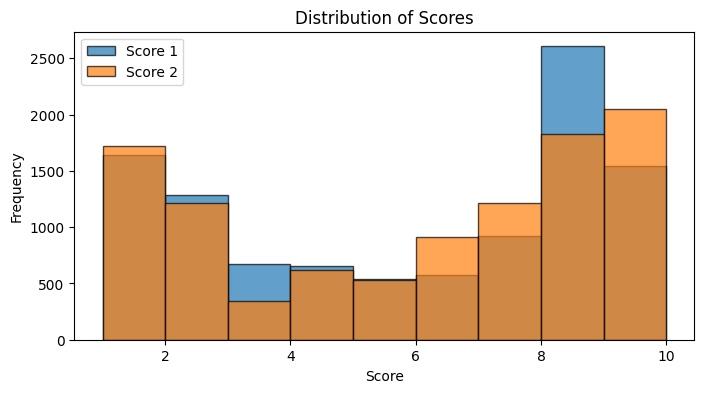

In [9]:
import matplotlib.pyplot as plt

# Assuming 'score' column is a string representation of a list; first convert it using ast.literal_eval
import ast


df['score_list'] = df['score'].apply(ast.literal_eval)
df['score1'] = df['score_list'].apply(lambda x: x[0])
df['score2'] = df['score_list'].apply(lambda x: x[1])

plt.figure(figsize=(8, 4))
plt.hist(df['score1'], bins=range(1, 11), alpha=0.7, label='Score 1', edgecolor='black')
plt.hist(df['score2'], bins=range(1, 11), alpha=0.7, label='Score 2', edgecolor='black')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")
plt.legend()
plt.show()


### Response Length

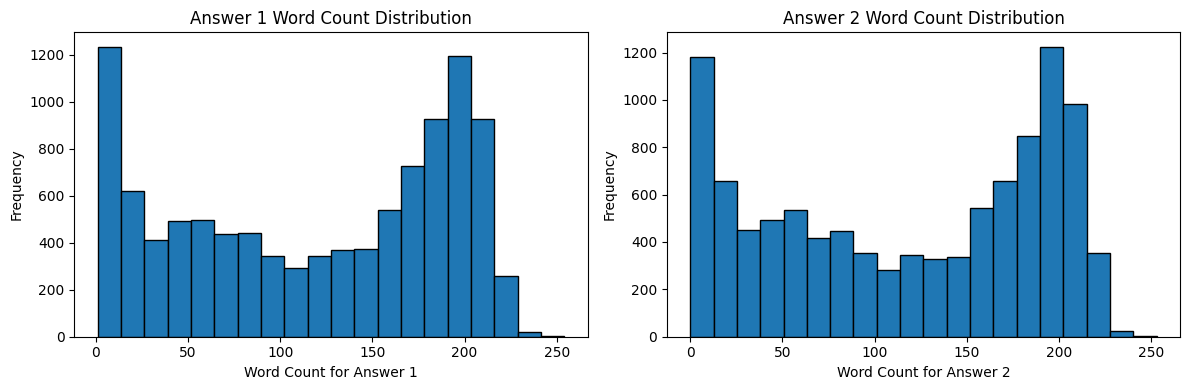

In [10]:
# Calculate word count for each response
df['len_answer1'] = df['answer1_body'].apply(lambda x: len(x.split()))
df['len_answer2'] = df['answer2_body'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['len_answer1'], bins=20, edgecolor='black')
plt.xlabel("Word Count for Answer 1")
plt.ylabel("Frequency")
plt.title("Answer 1 Word Count Distribution")

plt.subplot(1, 2, 2)
plt.hist(df['len_answer2'], bins=20, edgecolor='black')
plt.xlabel("Word Count for Answer 2")
plt.ylabel("Frequency")
plt.title("Answer 2 Word Count Distribution")

plt.tight_layout()
plt.show()


### Response Length and Score

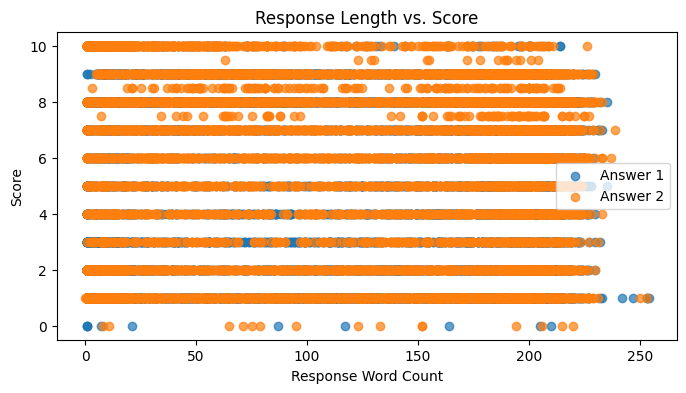

In [11]:
plt.figure(figsize=(8, 4))
plt.scatter(df['len_answer1'], df['score1'], alpha=0.7, label="Answer 1")
plt.scatter(df['len_answer2'], df['score2'], alpha=0.7, label="Answer 2")
plt.xlabel("Response Word Count")
plt.ylabel("Score")
plt.title("Response Length vs. Score")
plt.legend()
plt.show()


---
## Part 2: Critique analysis

In the second part of the notebook, assume that you have fine-tuned an LLM to act as an evaluator. This evaluator takes in as input an interaction between a user and another language model, as well as a set of evaluation criteria, and outputs a **score** and a **critique**.

To improve your evaluator model, you of course have to evaluate it to determine how well calibrated the scores and critiques are, for example in comparison with human annotators. In [this CSV](https://drive.google.com/file/d/1ObWojNE-sBzZjEA7YbCcnik7jdenVyIt/view?usp=drive_link) you'll find a set of results from such an evaluation across several benchmarks.

**Task:** Analyse the critiques and extract any insight that might be helpful in improving your model. Feel free to use both qualitative and quantitative techniques, and to jot down any hypotheses you might have about model behaviour and possible weaknesses. If it's useful feel free to factor the predicted score in your analysis, but make sure to focus on the critiques themselves.



Let's start by loading the file in this notebook:

In [12]:
# first, upload your file to Google Colab and load into a dataframe
critique_df = pd.read_csv('./critiques_for_re.csv').drop(columns="Unnamed: 0")

In [ ]:
critique_df.head()

                                                                                                                                                                                                                                                                                                                                                 user_input  \
0  USER: Each problem consists of three statements. Based on the first two statements, the third statement may be true, false, or uncertain.\n1. Oranges cost more than apples.\n2. Oranges cost less than bananas.\n3. Bananas cost more than apples and bananas cost more than orange.\nIf the first two statements are true, then the third statement is   
1                                                                                                                                                                                                                                                                                                         

To reiterate, your evaluator model receives as input:
- `user_input` the original user request to the language model being evaluated;
- `user_context` any additional information specified by the user, such as retrieved documents;
- `assistant_response` the response from the language model being evaluated;
- `evaluation_criteria` a set of guidelines for how to carry out the evaluation, sometimes including a score rubric and information on how to generate the critique.

For some of the benchmarks there is an additional column called `score` which is the ground-truth human-annotated score.

The evaluator model outputs the `eval_completion` entries, which contain, in XML format, two fields: a score and a critique. Here is an example:

In [14]:
critique_df.iloc[0]['eval_completion']

"<output>\n<score>3</score><critique>This response is rated 3 because it is a good response that answers the user's question, but it is not as creative or detailed as a 5 or 4 response. The assistant provides a clear and concise explanation of why the first statement is true if the third statement is true, and it provides an example to support its claim. However, it could have provided more detail about why the first statement is true in this case, such as explaining that if oranges cost more than apples and bananas cost more than oranges, then it is true that bananas cost more than apples. So the overall score is 3.</critique>\n</output>"

In [15]:
# TODO: critique analysis
#   - How good are the model critiques? How would you quantify this?
#   - Are there any common failure modes?
# As before, generate any artefacts or visualisations that would help you gather insight.

In [16]:
import pandas as pd

# Read the CSV file and drop the "Unnamed: 0" column
critique_df = pd.read_csv('./critiques_for_re.csv').drop(columns="Unnamed: 0")

# Get the counts of each unique value in the 'benchmark_name' column
benchmark_counts = critique_df['benchmark_name'].value_counts()

# Print each unique value with its occurrence count, one per line
for benchmark, count in benchmark_counts.items():
    print(f"{benchmark}: {count}")


huggingface_lmsys_mtBenchHumanJudgements_completions: 20
huggingface_mteb_summEval_completions: 20
huggingface_osunlp_mind2Web_completions: 20
